
### 1. Introduction

This dataset is a collection of images that are commonly used to train machine learning and computer vision algorithms. It is one of the most widely used datasets for machine learning research. The CIFAR-10 dataset contains 60,000 32x32 color images in 10 different classes. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 6,000 images of each class. Your goal is to correctly identify different object from a dataset of tens of thousands of color images.
* * * *
This notebook is divided in the following sections:
1. Introduction
1. Data preparation
    1. Load data
    1. Normalization, Reshape and Label encoding
    1. Visualize test and train sample
1. Model Building
    1. Split training and valdiation set
    1. Define the model architechture
    1. Set the optimizer and annealer
    1. Data augmentation
    1. Train model
1. Evaluate the model
    1. Training and validation curves
    1. Visualize Prediction
1. Prediction and submition
    1. Predict and Submit results
* * * *

In [34]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from  os import listdir
# import backend
import tensorflow as tf
# Model architecture
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D
from keras.layers import MaxPool2D, Activation, MaxPooling2D
from keras.layers.normalization import BatchNormalization

from keras.datasets import cifar10
# Annealer
from keras.callbacks import LearningRateScheduler

# Data processing
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.preprocessing import image

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns


# Progressor
from tqdm import tqdm
import h5py

In [2]:
tf.__version__

'2.2.0-rc2'

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

### 2. Data Prepration
**Load Data**

In [4]:
# Read File
print("Number of training sample: ", y_train.shape[0])
print("Number of test samples: ", y_test.shape[0])

Number of training sample:  50000
Number of test samples:  10000


In [5]:
# shape of data
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)
(50000, 1)
(10000, 1)


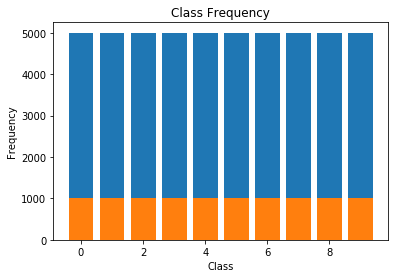

In [6]:
# Distribution of classes in training and testing samples

#To check class imbalance

unique, counts = np.unique(y_train, return_counts=True)
plt.bar(unique, counts)
unique, counts = np.unique(y_test, return_counts=True)
plt.bar(unique, counts)
plt.title('Class Frequency')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

We see that all classes are balanced.
* * * *

**Normalization, Reshape and Label Encoding**

***Normalization***
* We perform a grayscale normalization to reduce the effect of illumination's differences.
* If we perform normalization, CNN works faster.
***Reshape***
* Train and test images (32 x 32)
* We reshape all data to -1*28x28x1 4D matrices.

***Label Encoding***
* Encode labels to one hot vectors
> 2 => [0,0,1,0,0,0,0,0,0,0]
> 4 => [0,0,0,0,1,0,0,0,0,0]

In [7]:
# Function to reshape and scaling image
def Scale_Reshape(x):
    
    x_min = x.min(axis=(1, 2), keepdims=True)
    x_max = x.max(axis=(1, 2), keepdims=True)

    x = (x - x_min)/(x_max-x_min)
    
    x = x.reshape(-1, 32, 32, 3)
    return x


In [8]:
# Training data processing
train = Scale_Reshape(x_train)

# Test data processing
test = Scale_Reshape(x_test)

# Label processing

Y= y_train
# convert to one-hot
Y = Y.flatten()
Y = pd.get_dummies(Y)


print("train shape: ", train.shape)
print("test shape: ", test.shape)
print("one-hot label shape: ", Y.shape)

train shape:  (50000, 32, 32, 3)
test shape:  (10000, 32, 32, 3)
one-hot label shape:  (50000, 10)


In [9]:
# Label encoding
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
label_int = y_train.flatten().copy()
label_int = lb_make.fit_transform(label_int)

**Visualize test and train sample**
##### Train sample

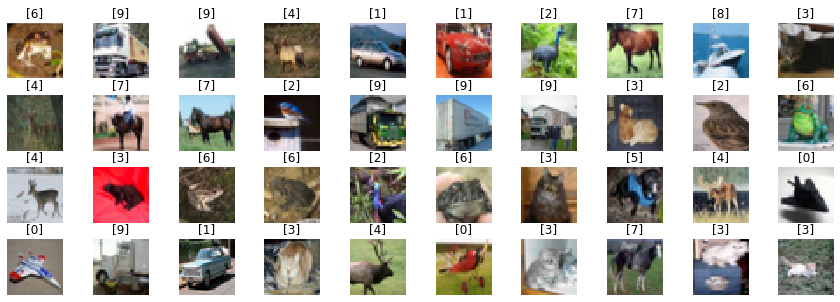

In [10]:
# visualizing training samples
plt.figure(figsize=(15,5))
for i in range(40):  
    plt.subplot(4, 10, i+1)
    plt.imshow(x_train[i].reshape((32, 32, 3)),cmap=plt.cm.hsv)
    plt.title(f"{y_train[i]}")
    plt.axis('off')
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()

##### Test sample

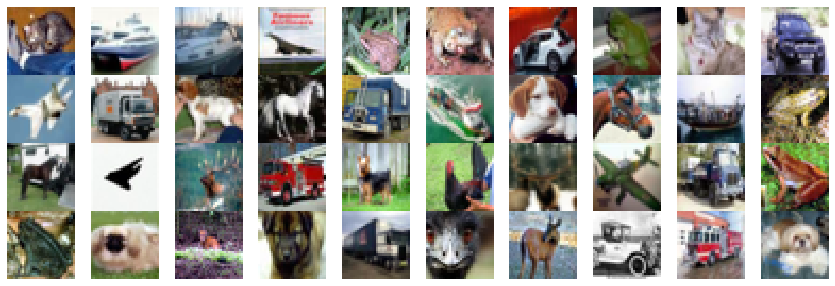

In [11]:
# visualizing test samples
plt.figure(figsize=(15,5))
for i in range(40):  
    plt.subplot(4, 10, i+1)
    plt.imshow(test[i].reshape((32,32, 3)),cmap=plt.cm.hsv)
    plt.axis('off')
plt.subplots_adjust(wspace=0.0, hspace=0.0)
plt.show()

### 3. Model Building: 

**Split training and valdiation set**

In [12]:
# split training and validation set.
X_train, X_val, Y_train, Y_val = train_test_split(train, Y, random_state=0, test_size=0.1)
print("X_train shape: ", X_train.shape)
print("Y_train shape: ", Y_train.shape)
print("X_val shape: ", X_val.shape)
print("Y_val shape: ", Y_val.shape)

X_train shape:  (45000, 32, 32, 3)
Y_train shape:  (45000, 10)
X_val shape:  (5000, 32, 32, 3)
Y_val shape:  (5000, 10)


**Define the model architechture**

**Convolutional neural networks (CNNs)** are the current **state-of-the-art model architecture** for image classification tasks. CNNs apply a series of filters to the raw pixel data of an image to extract and learn higher-level features, which the model can then use for classification. CNNs contains different components:

***Convolutional layers***, which apply a specified number of convolution filters to the image. For each subregion, the layer performs a set of mathematical operations to produce a single value in the output **feature map**. Convolutional layers then typically apply a **ReLU activation** function) to the output to introduce **nonlinearities** into the model.

***BatchNormalization layers***, Batch Normalization is a technical trick to make training faster.

***Dropout layers***, Dropout is a regularization method, where the layer randomly replaces a proportion of its weights to zero for each training sample. This forces the net to learn features in a distributed way, not relying to much on a particular weight, and therefore improves generalization.

***Activation layers***, Activation functions are really important for a any Neural Network to learn and make sense of something really complicated and Non-linear complex functional mappings between the inputs and response variable.They introduce **non-linear properties** to our Network.

***Pooling layers***, which downsample the image data extracted by the convolutional layers to reduce the dimensionality of the feature map in order to decrease processing time. A commonly used pooling algorithm is max pooling, which extracts subregions of the feature map (e.g., 2x2-pixel tiles), keeps their maximum value, and discards all other values. it gives **rotation invariant** feature extraction ability to model. 

***Dense (fully connected) layers***, which perform classification on the features extracted by the convolutional layers and downsampled by the pooling layers. In a dense layer, every node in the layer is connected to every node in the preceding layer.

Typically, a CNN is composed of a stack of convolutional modules that perform feature extraction. Each module consists of a convolutional layer followed by a pooling layer. The last convolutional module is followed by one or more dense layers that perform classification. The final dense layer in a CNN contains a single node for each target class in the model (all the possible classes the model may predict), with a softmax activation function to generate a value between 0–1 for each node (the sum of all these softmax values is equal to 1). We can interpret the softmax values for a given image as relative measurements of how likely it is that the image falls into each target class.



Let's build a model to classify the images in the CIFAR-10 dataset using the following CNN architecture:


In [13]:
# BUILD CONVOLUTIONAL NEURAL NETWORKS

model = Sequential()

model.add(Conv2D(64,  kernel_size = 3,kernel_initializer='he_normal', activation='relu', input_shape = (32, 32, 3)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Conv2D(128, kernel_size = 3, kernel_initializer='he_normal', strides=1, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, kernel_size = 3, strides=1, kernel_initializer='he_normal' ,padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, kernel_size = 3,kernel_initializer='he_normal', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))


model.add(Flatten())
model.add(Dense(512,kernel_initializer='he_normal', activation = "relu"))
model.add(Dropout(0.25))
model.add(Dense(10, kernel_initializer='glorot_uniform', activation = "softmax"))


# Compile the model
model.compile(loss="categorical_crossentropy", optimizer="Nadam", metrics=["accuracy"])

# Summary of model
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 64)        1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 64)        256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 128)       512       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 128)      

**Set the optimizer and annealer**

We train once with a smaller learning rate to ensure convergence. We then speed things up, only to reduce the learning rate by 10% every epoch. Keras has a function for this:

In [14]:
import math
# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.1
    drop = 0.5
    epochs_drop = 3.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

# learning schedule callback
annealer = LearningRateScheduler(step_decay)
callbacks_list = [annealer]


**Data augmentation**

In order to avoid overfitting problem, we need to expand artificially our dataset. We can make existing dataset even larger by altering the training data with small transformations.

For the data augmentation, i choosed to :

* Randomly rotate some training images by 10 degrees
* Randomly Zoom by 10% some training images
* Randomly shift images horizontally by 10% of the width
* Randomly shift images vertically by 10% of the height
* Randomly flip images horizontally.

I did not apply a vertical_flip since it could have lead to misclassify symetrical object like aeroplane and bird, truck and shi.

In [15]:
# data augumetation
datagen = ImageDataGenerator(
        rotation_range=0,  
        zoom_range = 0.0,  
        width_shift_range=0.1, 
        height_shift_range=0.1,
        horizontal_flip=False)

# data generator model to train and validation set
batch_size_1 = 128
train_gen = datagen.flow(X_train, Y_train, batch_size=batch_size_1)
val_gen = datagen.flow(X_val, Y_val, batch_size=batch_size_1)

**Generated sample**

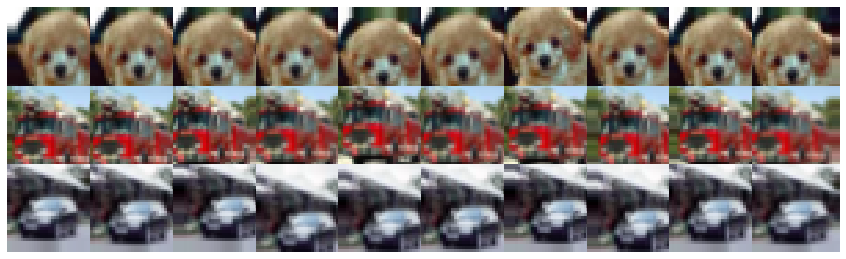

In [16]:
# visualizing augumented image
X_train_augmented = X_train[9,].reshape((1,32,32,3))
Y_train_augmented = np.array(Y_train.iloc[9,:]).reshape((1,10))
plt.figure(figsize=(15,4.5))
for i in range(30):  
    plt.subplot(3, 10, i+1)
    X_train2, Y_train2 = datagen.flow(X_train_augmented,Y_train_augmented).next()
    plt.imshow(X_train2[0].reshape((32,32,3)),cmap=plt.cm.gray)
    plt.axis('off')
    if i==9: X_train_augmented = X_train[2000,].reshape((1,32,32,3))
    if i==19: X_train_augmented = X_train[1180,].reshape((1,32,32,3))
plt.subplots_adjust(wspace=-0.1, hspace=-0.1)
plt.show()

**Train model**

In [17]:
# traing parameters
epochs = 30
batch_size = 128

In [18]:
# Fit the model
history = model.fit_generator(train_gen, 
                              epochs = epochs, 
                              steps_per_epoch = X_train.shape[0] // batch_size,
                              validation_data = val_gen,
                              validation_steps = X_val.shape[0] // batch_size,
                              
                              verbose=1)

Epoch 1/30
351/351 [==============================] - 47s 134ms/step - loss: 1.6500 - accuracy: 0.4321 - val_loss: 1.9149 - val_accuracy: 0.3542
Epoch 2/30
351/351 [==============================] - 43s 123ms/step - loss: 1.1602 - accuracy: 0.5928 - val_loss: 1.0416 - val_accuracy: 0.6205
Epoch 3/30
351/351 [==============================] - 44s 125ms/step - loss: 0.9756 - accuracy: 0.6537 - val_loss: 0.9657 - val_accuracy: 0.6739
Epoch 4/30
351/351 [==============================] - 47s 135ms/step - loss: 0.8733 - accuracy: 0.6967 - val_loss: 0.8964 - val_accuracy: 0.6886
Epoch 5/30
351/351 [==============================] - 48s 138ms/step - loss: 0.8078 - accuracy: 0.7165 - val_loss: 0.8596 - val_accuracy: 0.6847
Epoch 6/30
351/351 [==============================] - 49s 140ms/step - loss: 0.7509 - accuracy: 0.7402 - val_loss: 0.7407 - val_accuracy: 0.7514
Epoch 7/30
351/351 [==============================] - 49s 139ms/step - loss: 0.7000 - accuracy: 0.7571 - val_loss: 0.6177 - val_ac

In [19]:
final_loss, final_acc = model.evaluate(X_val, Y_val, verbose=1)
print("Final loss: {0:.4f}, final accuracy: {1:.4f}".format(final_loss, final_acc))

5000/5000 [==============================] - 5s 953us/step
Final loss: 0.5488, final accuracy: 0.8196


### 4. Evaluate the model

**Training and validation curves**



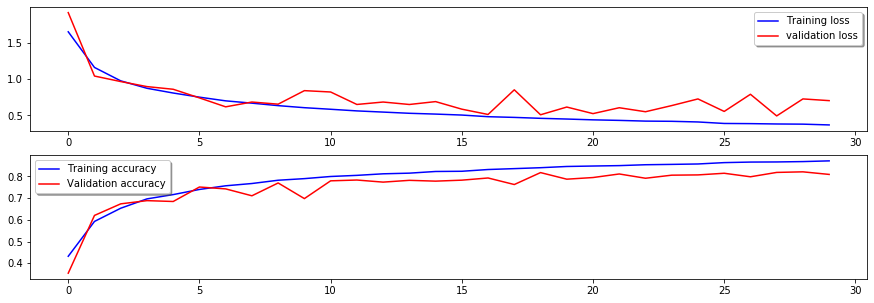

In [20]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1, figsize=(15, 5))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

**Visualize Result**

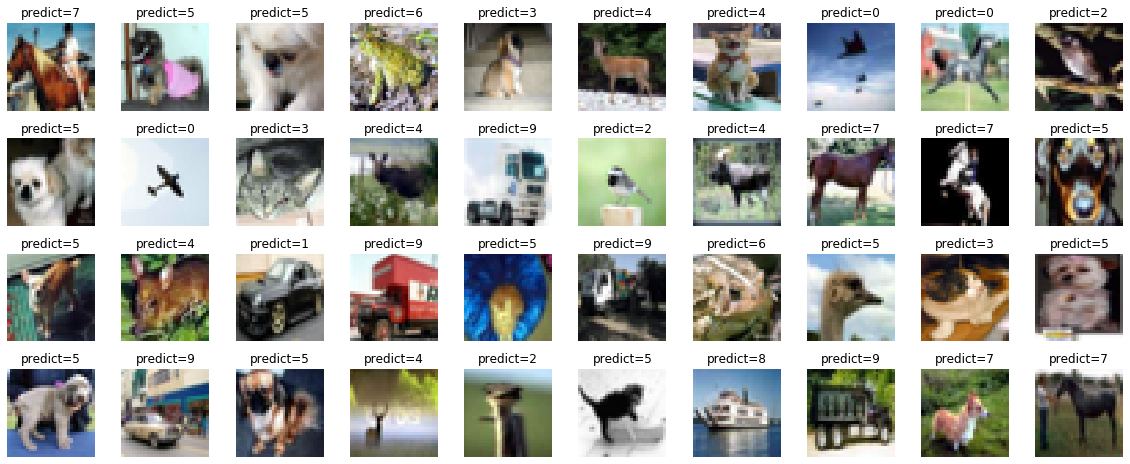

In [21]:
# making predictions
prediction = model.predict_classes(X_val)

# PREVIEW PREDICTIONS
plt.figure(figsize=(20,8))
for i in range(40):  
    plt.subplot(4, 10, i+1)
    plt.imshow(X_val[i].reshape((32,32,3)),cmap=plt.cm.gray)
    plt.title(f"predict={Y.columns.values[prediction[i]]}")
    plt.axis('off')
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()

### 5. Prediction and submition
**Predict and Submit results**

In [26]:
# prediction on test
prediction = model.predict_classes(test)
prediction

array([3, 8, 8, ..., 5, 1, 7], dtype=int64)

***Predicted samples distribution***

In [31]:
#test_ids.head()
prediction.shape

(10000,)

In [33]:
ddf=pd.DataFrame(prediction)
ddf.to_csv('pred.csv',header=False,index=False)

### References: 

https://keras.io/models/sequential/
https://keras.io/layers/core/
https://keras.io/layers/convolutional/
https://keras.io/layers/pooling/
https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6
https://www.kaggle.com/toregil/welcome-to-deep-learning-cnn-99
https://www.kaggle.com/kanncaa1/convolutional-neural-network-cnn-tutorial
https://github.com/MazenAly/Cifar100